<a href="https://colab.research.google.com/github/Rafelisha/Taekwondo-Movement-Classification-Using-CNN-LSTM-Based-on-Body-Pose-Estimation/blob/main/Model_TA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe opencv-python scikit-learn --quiet

import os, sys, IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import mediapipe as mp
import urllib.request

from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from mediapipe.tasks.python import vision
from mediapipe.tasks import python


In [ ]:
print("TensorFlow version:", tf.__version__)
print("Mediapipe version:", mp.__version__)

TensorFlow version: 2.19.0
Mediapipe version: 0.10.31


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### DATASET

In [ ]:
Data_dir = '/content/drive/MyDrive/Data'

Train_dir = os.path.join(Data_dir, 'Training')
Test_dir  = os.path.join(Data_dir, 'Testing')

Label_map = {
    'apchagi': 0,
    'idandollyochagi': 1,
    'yeopchagi': 2
}
label2idx = {v: k for k, v in Label_map.items()}
Num_Classes = len(Label_map)

print("Training dir :", Train_dir)
print("Testing dir  :", Test_dir)
print("Label map    :", label2idx)

print("\nTraining folders:", os.listdir(Train_dir))
print("Testing folders:", os.listdir(Test_dir))

# Parameters
Sequence_Len = 30      # Jumlah frame pervideo
Num_Landmarks   = 33
Num_coords     = 4       # x, y, z, visibility
Num_Angles     = 7
Base_Features  = Num_Landmarks * Num_coords
Num_Features     = Base_Features + Num_Angles

Video_exts = ('.mp4', '.avi', '.mov', '.mkv')

print("\nBase_Features\t\t:", Base_Features)
print("Num_Angels_Fetaures\t:", Num_Angles)
print("Num_Features\t\t:", Num_Features)

Training dir : /content/drive/MyDrive/Data/Training
Testing dir  : /content/drive/MyDrive/Data/Testing
Label map    : {0: 'apchagi', 1: 'idandollyochagi', 2: 'yeopchagi'}

Training folders: ['Apchagi_02.mp4', 'Idandollyochagi_02.mp4', 'Yeopchagi_02.mp4', 'Apchagi_03.mp4', 'Idandollyochagi_03.mp4', 'Yeopchagi_03.mp4', 'Apchagi_04.mp4', 'Idandollyochagi_04.mp4', 'Yeopchagi_04.mp4', 'Apchagi_05.mp4', 'Idandollyochagi_05.mp4', 'Yeopchagi_05.mp4', 'Apchagi_07.mp4', 'Idandollyochagi_07.mp4', 'Yeopchagi_07.mp4', 'Apchagi_08.mp4', 'Idandollyochagi_08.mp4', 'Yeopchagi_08.mp4', 'Apchagi_09.mp4', 'Idandollyochagi_09.mp4', 'Yeopchagi_09.mp4', 'Apchagi_11.mp4', 'Idandollyochagi_11.mp4', 'Yeopchagi_11.mp4', 'Apchagi_12.mp4', 'Idandollyochagi_12.mp4', 'Yeopchagi_12.mp4', 'Apchagi_14.mp4', 'Idandollyochagi_14.mp4', 'Yeopchagi_14.mp4', 'Apchagi_15.mp4', 'Idandollyochagi_15.mp4', 'Yeopchagi_15.mp4', 'Apchagi_16.mp4', 'Idandollyochagi_16.mp4', 'Yeopchagi_16.mp4']
Testing folders: ['Apchagi_01.mp4', 'Idan

### PREPROCESSING

In [ ]:
MODEL_PATH = 'pose_landmarker_full.task'
if not os.path.exists(MODEL_PATH):
    print("Downloading pose landmarker model...")
    #url = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/latest/pose_landmarker_lite.task"
    url = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_full/float16/latest/pose_landmarker_full.task"
    # url = "https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/latest/pose_landmarker_heavy.task"
    urllib.request.urlretrieve(url, MODEL_PATH)
    print("Model downloaded successfully!")

print("MediaPipe Pose initialized")

Model downloaded successfully!
MediaPipe Pose initialized


In [ ]:
def normalize_pose(keypoints):
    """
    Normalize pose keypoints relatif ke hip center,
    dan diskalakan dengan panjang torso.
    keypoints: vektor (Base_Features,) = 33*4
    """
    kp = keypoints.reshape(Num_Landmarks, Num_coords).astype(np.float32)

    # Hip center (23=left hip, 24=right hip)
    hip_center = (kp[23, :3] + kp[24, :3]) / 2.0

    # Translasi relatif hip
    kp[:, :3] = kp[:, :3] - hip_center

    # Skala dengan panjang torso (shoulder center - hip center)
    shoulder_center = (kp[11, :3] + kp[12, :3]) / 2.0
    torso_length = np.linalg.norm(shoulder_center - hip_center)

    if torso_length > 1e-6:
        kp[:, :3] = kp[:, :3] / torso_length

    return kp.flatten()


def compute_joint_angles(keypoints):
    """
    Hitung 7 sudut sendi bagian gerakan tendangan.
    """
    kp = keypoints.reshape(Num_Landmarks, Num_coords)
    angles = []

    angle_joints = [
        (24, 26, 28),  # right hip-knee-ankle
        (26, 28, 32),  # right knee-ankle-foot
        (23, 25, 27),  # left hip-knee-ankle
        (25, 27, 31),  # left knee-ankle-foot
        (12, 24, 26),  # right shoulder-hip-knee
        (11, 23, 25),  # left shoulder-hip-knee
        (12, 24, 28),  # right shoulder-hip-ankle
    ]

    for p1, p2, p3 in angle_joints:
        v1 = kp[p1, :3] - kp[p2, :3]
        v2 = kp[p3, :3] - kp[p2, :3]

        norm_product = np.linalg.norm(v1) * np.linalg.norm(v2)
        if norm_product > 1e-6:
            cos_angle = np.dot(v1, v2) / norm_product
            cos_angle = np.clip(cos_angle, -1.0, 1.0)
            angle = np.arccos(cos_angle)
        else:
            angle = 0.0

        angles.append(angle)

    return np.array(angles, dtype=np.float32)

print("Pose normalization & angle computation functions defined.")

Pose normalization & angle computation functions defined.


### VIDEO LANDMARK + CSV

In [ ]:
# buat folder output (video dan fitur csv)

Report_dir    = os.path.join(Data_dir, "MC1_Pose_Estimation_Output")
Annotated_dir = os.path.join(Report_dir, "annotated_videos")
CSV_dir       = os.path.join(Report_dir, "landmarks_csv")
Merged_dir    = os.path.join(Report_dir, "merged_per_class")

os.makedirs(Annotated_dir, exist_ok=True)
os.makedirs(CSV_dir, exist_ok=True)
os.makedirs(Merged_dir, exist_ok=True)

print("Output disimpan di:", Report_dir)


In [ ]:
# buat kolom fitur di csv
def build_csv_columns():
    raw_cols  = [f"raw_lm{i}_{c}"  for i in range(33) for c in ["x","y","z","vis"]]
    norm_cols = [f"norm_lm{i}_{c}" for i in range(33) for c in ["x","y","z","vis"]]
    ang_cols_rad = [f"angle{i+1}_rad" for i in range(Num_Angles)]
    ang_cols_deg = [f"angle{i+1}_deg" for i in range(Num_Angles)]
    return (["video","class","frame_index","fps","pose_detected","mean_visibility"]
            + raw_cols + norm_cols + ang_cols_rad + ang_cols_deg)


In [ ]:
def draw_landmarks_on_image(bgr_image, detection_result):
    """
    membuat video/frame hasil anotasi: frame asli + overlay skeleton pose
    """
    # Koneksi antar landmark untuk membentuk skeleton
    POSE_CONNECTIONS = [
        (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
        (9, 10), (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21),
        (17, 19), (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20),
        (11, 23), (12, 24), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28),
        (27, 29), (28, 30), (29, 31), (30, 32), (27, 31), (28, 32)
    ]

    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = bgr_image.copy()

    # Loop setiap pose
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # gambar garis landmark
        for connection in POSE_CONNECTIONS:
            start_idx = connection[0]
            end_idx = connection[1]

            if start_idx < len(pose_landmarks) and end_idx < len(pose_landmarks):
                start_point = pose_landmarks[start_idx]
                end_point = pose_landmarks[end_idx]

                height, width = annotated_image.shape[:2]
                start_pixel = (int(start_point.x * width), int(start_point.y * height))
                end_pixel = (int(end_point.x * width), int(end_point.y * height))

                cv2.line(annotated_image, start_pixel, end_pixel, (0, 255, 0), 2)

        # gamabr titik landmarks
        for landmark in pose_landmarks:
            height, width = annotated_image.shape[:2]
            pixel_x = int(landmark.x * width)
            pixel_y = int(landmark.y * height)
            cv2.circle(annotated_image, (pixel_x, pixel_y), 5, (0, 0, 255), -1)

    return annotated_image

In [ ]:
def export_video_and_csv(video_path, out_video_path, out_csv_path, class_name="unknown"):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Gagal buka video: {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    fps = fps if fps and fps > 0 else 30.0
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_video_path, fourcc, fps, (w, h))
    if not writer.isOpened():
        cap.release()
        raise RuntimeError(f"Gagal buat VideoWriter: {out_video_path}")

    cols = build_csv_columns()
    rows = []

    # inisialisasi mediapipe poselandmarker (Tasks API)
    base_options = python.BaseOptions(model_asset_path=MODEL_PATH)
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        running_mode=vision.RunningMode.VIDEO,
        min_pose_detection_confidence=0.5,
        min_pose_presence_confidence=0.5,
        min_tracking_confidence=0.5
    )

    with vision.PoseLandmarker.create_from_options(options) as landmarker:
        frame_idx = 0
        timestamp_ms = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # konvert BGR ke RGB
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)

            # deteksi pose landmark
            timestamp_ms = int(frame_idx * (1000 / fps))
            results = landmarker.detect_for_video(mp_image, timestamp_ms) # hasil

            out_frame = frame.copy()

            if results.pose_landmarks and len(results.pose_landmarks) > 0:
                # gambar overlay landmark di frame
                out_frame = draw_landmarks_on_image(out_frame, results)

                # ekstrak landmark
                lms = results.pose_landmarks[0]
                raw_kp = np.array([[lm.x, lm.y, lm.z, lm.visibility] for lm in lms], dtype=np.float32).flatten()
                mean_vis = float(np.mean(raw_kp.reshape(33, 4)[:, 3]))

                # Normalize and compute angles
                norm_kp = normalize_pose(raw_kp)
                angles_rad = compute_joint_angles(norm_kp)
                angles_deg = np.degrees(angles_rad).astype(np.float32)

                pose_detected = 1
                raw_vals = raw_kp.tolist()
                norm_vals = norm_kp.tolist()
                ang_rad_vals = angles_rad.astype(np.float32).tolist()
                ang_deg_vals = angles_deg.astype(np.float32).tolist()

                # Overlay joint angles
                cv2.rectangle(out_frame, (10, 65), (620, 65 + 30*(Num_Angles+1)), (255, 255, 255), -1)
                cv2.putText(out_frame, "Angles (deg):", (15, 95),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
                for i, val in enumerate(angles_deg):
                    cv2.putText(out_frame, f"A{i+1}: {val:.1f}", (15, 95 + 30*(i+1)),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 0), 2)
            else:
                pose_detected = 0
                mean_vis = 0.0
                raw_vals = [0.0] * (33 * 4)
                norm_vals = [0.0] * (33 * 4)
                ang_rad_vals = [0.0] * Num_Angles
                ang_deg_vals = [0.0] * Num_Angles

            # Overlay info
            cv2.rectangle(out_frame, (10, 2), (700, 60), (255, 255, 255), -1)
            cv2.putText(out_frame, f"Class: {class_name} | Frame: {frame_idx}", (15, 45),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 0, 0), 2)

            writer.write(out_frame)

            rows.append(
                [os.path.basename(video_path), class_name, frame_idx, fps, pose_detected, mean_vis]
                + raw_vals + norm_vals + ang_rad_vals + ang_deg_vals
            )

            frame_idx += 1

    cap.release()
    writer.release()

    df = pd.DataFrame(rows, columns=cols)
    os.makedirs(os.path.dirname(out_csv_path), exist_ok=True)
    df.to_csv(out_csv_path, index=False)

    return frame_idx

In [ ]:
def merge_videos(video_paths, out_path):
    video_paths = [p for p in video_paths if os.path.exists(p)]
    if len(video_paths) == 0:
        raise ValueError("Tidak ada video untuk digabung.")

    cap0 = cv2.VideoCapture(video_paths[0])
    fps = cap0.get(cv2.CAP_PROP_FPS)
    fps = fps if fps and fps > 0 else 30.0
    w = int(cap0.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap0.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap0.release()

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))
    if not writer.isOpened():
        raise RuntimeError(f"Gagal buat VideoWriter: {out_path}")

    for vp in video_paths:
        cap = cv2.VideoCapture(vp)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame.shape[1] != w or frame.shape[0] != h:
                frame = cv2.resize(frame, (w, h))
            writer.write(frame)
        cap.release()

    writer.release()


In [ ]:
def export_outputs_for_folder(input_dir, split_name="train", merge_per_class=True):
    files = [f for f in sorted(os.listdir(input_dir)) if f.lower().endswith(Video_exts)]
    print(f"[{split_name}] total video: {len(files)}")

    annotated_by_class = {}

    for fname in files:
        cls = fname.split("_")[0].lower()
        in_path = os.path.join(input_dir, fname)

        out_vid = os.path.join(Annotated_dir, f"{split_name}_{os.path.splitext(fname)[0]}_annotated.mp4")
        out_csv = os.path.join(CSV_dir,       f"{split_name}_{os.path.splitext(fname)[0]}.csv")

        n = export_video_and_csv(in_path, out_vid, out_csv, class_name=cls)
        annotated_by_class.setdefault(cls, []).append(out_vid)
        print(f"[OK] {fname} | class={cls} | frames={n}")

    if merge_per_class:
        for cls, vids in annotated_by_class.items():
            merged_path = os.path.join(Merged_dir, f"{split_name}_MERGED_{cls}.mp4")
            merge_videos(vids, merged_path)
            print(f"[MERGED] class={cls} -> {merged_path}")


export_outputs_for_folder(Train_dir, split_name="train", merge_per_class=True)
export_outputs_for_folder(Test_dir,  split_name="test",  merge_per_class=True)

print("Selesai. Output ada di:", Report_dir)


[train] total video: 36
[OK] Apchagi_02.mp4 | class=apchagi | frames=51
[OK] Apchagi_03.mp4 | class=apchagi | frames=47
[OK] Apchagi_04.mp4 | class=apchagi | frames=48
[OK] Apchagi_05.mp4 | class=apchagi | frames=54
[OK] Apchagi_07.mp4 | class=apchagi | frames=48
[OK] Apchagi_08.mp4 | class=apchagi | frames=49
[OK] Apchagi_09.mp4 | class=apchagi | frames=41
[OK] Apchagi_11.mp4 | class=apchagi | frames=40
[OK] Apchagi_12.mp4 | class=apchagi | frames=35
[OK] Apchagi_14.mp4 | class=apchagi | frames=46
[OK] Apchagi_15.mp4 | class=apchagi | frames=51
[OK] Apchagi_16.mp4 | class=apchagi | frames=48
[OK] Idandollyochagi_02.mp4 | class=idandollyochagi | frames=42
[OK] Idandollyochagi_03.mp4 | class=idandollyochagi | frames=36
[OK] Idandollyochagi_04.mp4 | class=idandollyochagi | frames=40
[OK] Idandollyochagi_05.mp4 | class=idandollyochagi | frames=55
[OK] Idandollyochagi_07.mp4 | class=idandollyochagi | frames=37
[OK] Idandollyochagi_08.mp4 | class=idandollyochagi | frames=45
[OK] Idandollyoc

In [ ]:
def get_class_from_filename(fname: str) -> str:
    return os.path.splitext(os.path.basename(fname))[0].split("_")[0].lower()

def get_feature_columns_from_csv(num_angles=Num_Angles):
    norm_cols = [f"norm_lm{i}_{c}" for i in range(33) for c in ["x","y","z","vis"]]
    ang_cols  = [f"angle{i+1}_rad" for i in range(num_angles)]
    return norm_cols + ang_cols  # total = 132 + 7 = 139

def load_sequence_from_csv(csv_path, sequence_length=Sequence_Len):
    df = pd.read_csv(csv_path)

    feat_cols = get_feature_columns_from_csv()
    feat = df[feat_cols].to_numpy(dtype=np.float32)  # (T, 139)

    # crop/pad ke Sequence_Len
    T = feat.shape[0]
    if T < sequence_length:
        pad = np.zeros((sequence_length - T, feat.shape[1]), dtype=np.float32)
        feat = np.vstack([feat, pad])
    elif T > sequence_length:
        feat = feat[:sequence_length]

    return feat  # (Sequence_Len, Num_Features=139)


### LOAD DATA

In [ ]:
def build_dataset_from_csv_folder(csv_dir, split_prefix, label_map, sequence_length=Sequence_Len):
    """
    split_prefix: 'train_' atau 'test_'
    Return:
      X: (N, Sequence_Len, Num_Features)
      y: (N, Num_Classes) one-hot  (biar cocok dengan kode kamu)
    """
    files = [f for f in sorted(os.listdir(csv_dir)) if f.startswith(split_prefix) and f.endswith(".csv")]
    print(f"{split_prefix} CSV files:", len(files))

    X_list = []
    y_list = []

    for f in files:
        # ambil class dari nama video di filename csv: train_<video>.csv
        # contoh: train_apchagi_01.csv -> class = apchagi
        class_name = f[len(split_prefix):].split("_")[0].lower()

        if class_name not in label_map:
            # kalau ada file yang tidak termasuk label_map, skip
            continue

        seq = load_sequence_from_csv(os.path.join(csv_dir, f), sequence_length=sequence_length)
        X_list.append(seq)

        idx = label_map[class_name]
        onehot = np.zeros((Num_Classes,), dtype=np.float32)
        onehot[idx] = 1.0
        y_list.append(onehot)

    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    return X, y


In [ ]:
CSV_dir = os.path.join(Data_dir, "MC1_Pose_Estimation_Output", "landmarks_csv")

X_all, y_all = build_dataset_from_csv_folder(CSV_dir, "train_", Label_map, sequence_length=Sequence_Len)
X_test, y_test = build_dataset_from_csv_folder(CSV_dir, "test_", Label_map, sequence_length=Sequence_Len)

print("X_all :", X_all.shape, "y_all :", y_all.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# sanity check
print("Num_Features (CSV):", X_all.shape[-1], "expected:", (33*4 + Num_Angles))


train_ CSV files: 36
test_ CSV files: 12
X_all : (36, 30, 139) y_all : (36, 3)
X_test: (12, 30, 139) y_test: (12, 3)
Num_Features (CSV): 139 expected: 139


In [ ]:
def augment_sequence(sequence,
                     noise_std=0.01,
                     time_shift_max=3,
                     rotate_deg=5.0,
                     use_rotation=True,
                     use_flip=True):
    """
    Augment satu sequence fitur: (Sequence_Len, Num_Features)
    - Rotasi kecil 5 derajat (arah acak +5/-5)
    - Gaussian noise
    - Time shifting
    """
    seq_copy = sequence.copy()
    T = seq_copy.shape[0]

    # 1. Rotation (50% chance)
    if use_rotation and np.random.rand() > 0.5:
        angle_deg = rotate_deg
        if np.random.rand() > 0.5:
            angle_deg = -angle_deg

        theta = np.deg2rad(angle_deg)
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta),  np.cos(theta)]],
                     dtype=np.float32)

        pose = seq_copy[:, :Base_Features].reshape(T, Num_Landmarks, Num_coords)
        xy = pose[..., :2]
        xy_rot = np.einsum('ij,tlj->tli', R, xy)
        pose[..., :2] = xy_rot
        seq_copy[:, :Base_Features] = pose.reshape(T, Base_Features)

    # 2. Flip horizontal (50% chance)
    if use_flip and np.random.rand() > 0.5:
        pose = seq_copy[:, :Base_Features].reshape(T, Num_Landmarks, Num_coords)
        pose[..., 0] *= -1.0
        seq_copy[:, :Base_Features] = pose.reshape(T, Base_Features)

    # 3. Gaussian noise (50% chance)
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, noise_std, seq_copy.shape).astype(np.float32)
        seq_copy = seq_copy + noise

    # 4. Time shifting (50% chance)
    if time_shift_max > 0 and np.random.rand() > 0.5:
        shift = np.random.randint(-time_shift_max, time_shift_max + 1)
        seq_copy = np.roll(seq_copy, shift, axis=0)

    return seq_copy


def create_augmented_dataset(X, y, augmentation_factor=3):
    """
    Membuat dataset baru: data asli + beberapa versi augment.
    augmentation_factor = berapa kali augment per sample.
    Return:
      X_all = [X_asli; X_aug1; X_aug2; ...]
      y_all = [y_asli; y; y; ...]
    """
    print(f"Creating {augmentation_factor}x augmented dataset...")

    X_aug_list = [X]
    y_aug_list = [y]

    for i in range(augmentation_factor):
        print(f"  Generating augmentation set {i+1}/{augmentation_factor}...")
        X_aug = np.array([augment_sequence(seq) for seq in X])
        X_aug_list.append(X_aug)
        y_aug_list.append(y)

    X_augmented = np.vstack(X_aug_list)
    y_augmented = np.vstack(y_aug_list)

    print(f"Original dataset: {X.shape}")
    print(f"Augmented dataset: {X_augmented.shape}")

    return X_augmented, y_augmented

print("Data augmentation functions defined.")


Data augmentation functions defined.


### SPLI DATA DAN AUGMENTASI

In [ ]:
print("\n" + "="*80)
print("SPLIT TRAIN / VALIDATION")
print("="*80)

y_all_labels = np.argmax(y_all, axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.3,
    random_state=42,
    stratify=y_all_labels
)
print("\nSebelum augmentasi:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

print("\n" + "="*80)
print("AUGMENTASI DATA TRAINING")
print("="*80)

# augmentation_factor=2 → total train = 3x (asli + 2x augment)
X_train_aug, y_train_aug = create_augmented_dataset(
    X_train, y_train,
    augmentation_factor=3
)

print("\nSetelah augmentasi:")
print("X_train_aug:", X_train_aug.shape)
print("y_train_aug:", y_train_aug.shape)
print("X_val      :", X_val.shape)
print("y_val      :", y_val.shape)
print("X_test     :", X_test.shape)
print("y_test     :", y_test.shape)



SPLIT TRAIN / VALIDATION

Sebelum augmentasi:
X_train: (25, 30, 139)
y_train: (25, 3)
X_val  : (11, 30, 139)
y_val  : (11, 3)
X_test : (12, 30, 139)
y_test : (12, 3)

AUGMENTASI DATA TRAINING
Creating 3x augmented dataset...
  Generating augmentation set 1/3...
  Generating augmentation set 2/3...
  Generating augmentation set 3/3...
Original dataset: (25, 30, 139)
Augmented dataset: (100, 30, 139)

Setelah augmentasi:
X_train_aug: (100, 30, 139)
y_train_aug: (100, 3)
X_val      : (11, 30, 139)
y_val      : (11, 3)
X_test     : (12, 30, 139)
y_test     : (12, 3)


In [ ]:
print("\n" + "="*80)
print("NORMALISASI DATA")
print("="*80)

print("\nData Sebelum normalisasi:")
print("X_train_norm:", X_train_aug.mean(), "std:", X_train_aug.std())
print("X_val_norm  :", X_val.mean(), "std:", X_val.std())
print("X_test_norm :", X_test.mean(), "std:", X_test.std())

feat_train = X_train_aug.reshape(-1, Num_Features)
feat_mean  = feat_train.mean(axis=0)
feat_std   = feat_train.std(axis=0) + 1e-8

X_train_norm = (X_train_aug - feat_mean) / feat_std
X_val_norm   = (X_val       - feat_mean) / feat_std
X_test_norm  = (X_test      - feat_mean) / feat_std

print("\nData setelah normalisasi:")
print("X_train_norm:", X_train_norm.mean(), "std:", X_train_norm.std())
print("X_val_norm  :", X_val_norm.mean(), "std:", X_val_norm.std())
print("X_test_norm :", X_test_norm.mean(), "std:", X_test_norm.std())



NORMALISASI DATA

Data Sebelum normalisasi:
X_train_norm: 0.23903477 std: 0.59318864
X_val_norm  : 0.2394775 std: 0.5892499
X_test_norm : 0.23812278 std: 0.6009278

Data setelah normalisasi:
X_train_norm: -4.12624e-05 std: 0.9999998
X_val_norm  : 0.11040669 std: 0.9496025
X_test_norm : -0.01398201 std: 0.89640915


MENYIMPAN DATA

In [ ]:
print("\n" + "="*80)
print("MENYIMPAN DATASET KE .NPY")
print("="*80)

SAVE_DIR = "/content/drive/MyDrive/taekwondo_pose_npy"
os.makedirs(SAVE_DIR, exist_ok=True)

print("\nSaving preprocessed data...")
np.save(os.path.join(SAVE_DIR, "X_train_norm.npy"), X_train_norm)
np.save(os.path.join(SAVE_DIR, "y_train_norm.npy"), y_train_aug)
np.save(os.path.join(SAVE_DIR, "X_val_norm.npy"),   X_val_norm)
np.save(os.path.join(SAVE_DIR, "y_val_norm.npy"),   y_val)
np.save(os.path.join(SAVE_DIR, "X_test_norm.npy"),  X_test_norm)
np.save(os.path.join(SAVE_DIR, "y_test_norm.npy"),  y_test)

np.save(os.path.join(SAVE_DIR, "feat_mean.npy"), feat_mean)
np.save(os.path.join(SAVE_DIR, "feat_std.npy"),  feat_std)

print("Data saved successfully!", SAVE_DIR)


MENYIMPAN DATASET KE .NPY

Saving preprocessed data...
Data saved successfully! /content/drive/MyDrive/taekwondo_pose_npy


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/taekwondo_pose_npy"

X_train_norm = np.load(os.path.join(SAVE_DIR, "X_train_norm.npy"))
y_train_aug  = np.load(os.path.join(SAVE_DIR, "y_train_norm.npy"))
X_val_norm   = np.load(os.path.join(SAVE_DIR, "X_val_norm.npy"))
y_val        = np.load(os.path.join(SAVE_DIR, "y_val_norm.npy"))
X_test_norm  = np.load(os.path.join(SAVE_DIR, "X_test_norm.npy"))
y_test       = np.load(os.path.join(SAVE_DIR, "y_test_norm.npy"))

feat_mean = np.load(os.path.join(SAVE_DIR, "feat_mean.npy"))
feat_std  = np.load(os.path.join(SAVE_DIR, "feat_std.npy"))

print("Loaded:")
print("X_train_norm:", X_train_norm.shape)
print("X_val_norm  :", X_val_norm.shape)
print("X_test_norm :", X_test_norm.shape)

Loaded:
X_train_norm: (100, 30, 139)
X_val_norm  : (11, 30, 139)
X_test_norm : (12, 30, 139)


### MODEL CNN + 2 LSTM

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM,
    Dense, Dropout, BatchNormalization, Masking
)

def build_model(sequence_len, num_features, num_classes):
    """
    Model CNN-LSTM (tanpa Bidirectional):
    - Conv1D + MaxPooling untuk ekstrak pola spasial
    - LSTM berlapis untuk pola temporal
    """
    inputs = Input(shape=(sequence_len, num_features), name='input')

    # 1) Masking: abaikan padding (nilai 0)
    x = Masking(mask_value=0., name='masking')(inputs)

    # 2) Conv1D block
    x = Conv1D(64, kernel_size=5, activation='relu',
               padding='same', name='conv1d_1')(x)
    x = BatchNormalization(name='bn_1')(x)
    x = MaxPooling1D(pool_size=2, name='pool_1')(x)
    x = Dropout(0.2, name='dropout_1')(x)

    # 3) LSTM pertama
    x = LSTM(64, return_sequences=True, name='lstm_1')(x)
    x = Dropout(0.2, name='dropout_2')(x)

    # 4) LSTM kedua (keluaran last timestep)
    x = LSTM(32, return_sequences=False, name='lstm_2')(x)
    x = Dropout(0.2, name='dropout_3')(x)

    # 5) Dense + Dropout
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_4')(x)

    # 6) Output softmax
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='Taekwondo_Classifier')

    return model

print("Model architecture function defined.")

print("\n" + "="*80)
print("Building Model")
print("="*80)

tf.random.set_seed(42)
np.random.seed(42)

model_01 = build_model(
    sequence_len =Sequence_Len ,
    num_features=Num_Features,
    num_classes=Num_Classes
)

model_01.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_01.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "Taekwondo_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30, 139)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 30, 139)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │        44,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling1D)           │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,547 (361.51 KB)

 Trainable params: 92,419 (361.01 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:

print("\n" + "="*80)
print("Training Model")
print("="*80)

MODEL_SAVE_PATH = '/content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_2LAYER.h5'
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-4,
        verbose=1
    ),
    ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history_01 = model_01.fit(
    X_train_norm, y_train_aug,
    validation_data=(X_val_norm, y_val),
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    shuffle=True
)



Training Model
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1769 - loss: 1.1409
Epoch 1: val_accuracy improved from -inf to 0.36364, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_2LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.1807 - loss: 1.1407 - val_accuracy: 0.3636 - val_loss: 1.1030 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4140 - loss: 1.0669
Epoch 2: val_accuracy improved from 0.36364 to 0.45455, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_2LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4130 - loss: 1.0669 - val_accuracy: 0.4545 - val_loss: 1.0807 - learning_rate: 1.0000e-04
Epoch 3/50
10/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4943 - loss: 1.0148
Epoch 3: val_accuracy improved from 0.45455 to 0.63636, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_2LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4967 - loss: 1.0136 - val_accuracy: 0.6364 - val_loss: 1.0467 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5490 - loss: 1.0040
Epoch 4: val_accuracy improved from 0.63636 to 0.72727, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_2LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5477 - loss: 1.0033 - val_accuracy: 0.7273 - val_loss: 1.0043 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6251 - loss: 0.9504
Epoch 5: val_accuracy did not improve from 0.72727
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6269 - loss: 0.9492 - val_accuracy: 0.7273 - val_loss: 0.9602 - learning_rate: 1.0000e-04
Epoch 6/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6696 - loss: 0.9194
Epoch 6: val_accuracy did not improve from 0.72727
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6697 - loss: 0.9174 - val_accuracy: 0.7273 - val_loss: 0.9176 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6900 - loss: 0.8772
Epoch 7: val_accuracy did not improve from 0.72727
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6907 - loss: 0.8761 - val_accuracy: 0.7273 - val_loss: 0.8722 - learning_rate: 1.0000e-04
Epoch 8/50
13/13

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.3630 - val_accuracy: 0.9091 - val_loss: 0.4236 - learning_rate: 1.0000e-04
Epoch 21/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.3330
Epoch 21: val_accuracy did not improve from 0.90909
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.3321 - val_accuracy: 0.9091 - val_loss: 0.3970 - learning_rate: 1.0000e-04
Epoch 22/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9894 - loss: 0.2995
Epoch 22: val_accuracy did not improve from 0.90909
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9895 - loss: 0.3014 - val_accuracy: 0.9091 - val_loss: 0.3761 - learning_rate: 1.0000e-04
Epoch 23/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.2725
Epoch 23: val_accuracy did not improve from 0.90909
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.2725 - val_accuracy: 0.9091 - val_loss: 0.3535 - learning_rate: 1.0000e-04
Epoch 24/5

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.2252 - val_accuracy: 1.0000 - val_loss: 0.3056 - learning_rate: 1.0000e-04
Epoch 26/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.2017
Epoch 26: val_accuracy did not improve from 1.00000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.2022 - val_accuracy: 1.0000 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 27/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1872
Epoch 27: val_accuracy did not improve from 1.00000
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 1.0000 - loss: 0.1866 - val_accuracy: 1.0000 - val_loss: 0.2657 - learning_rate: 1.0000e-04
Epoch 28/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1945
Epoch 28: val_accuracy did not improve from 1.00000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.1931 - val_accuracy: 1.0000 - val_loss: 0.2497 - learning_rate: 1.0000e-04
Epoch 29/5


Hasil Visualisasi


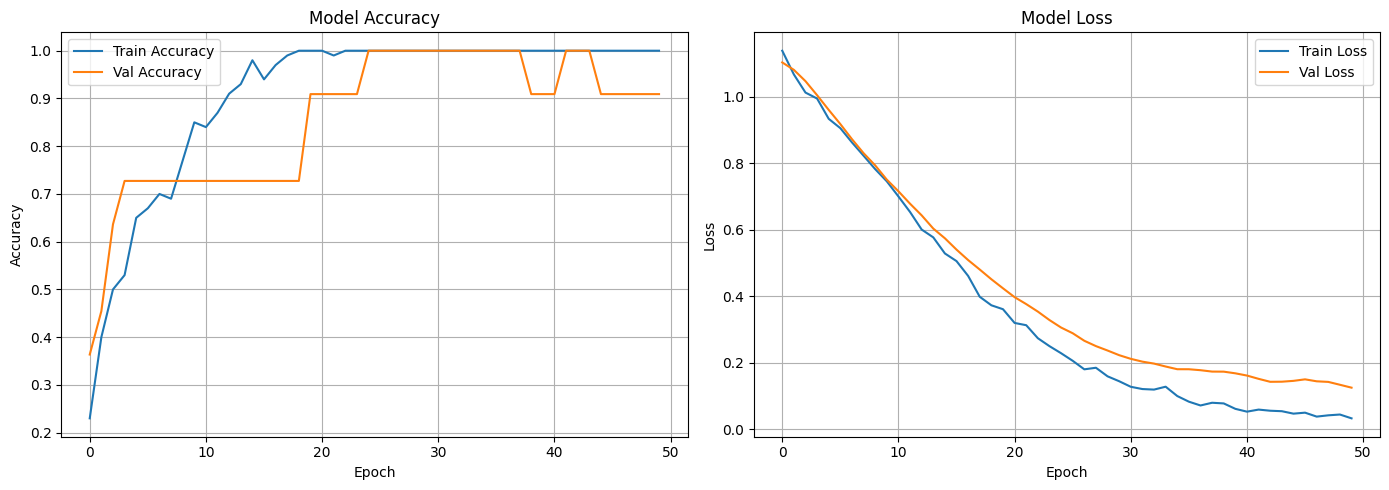

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


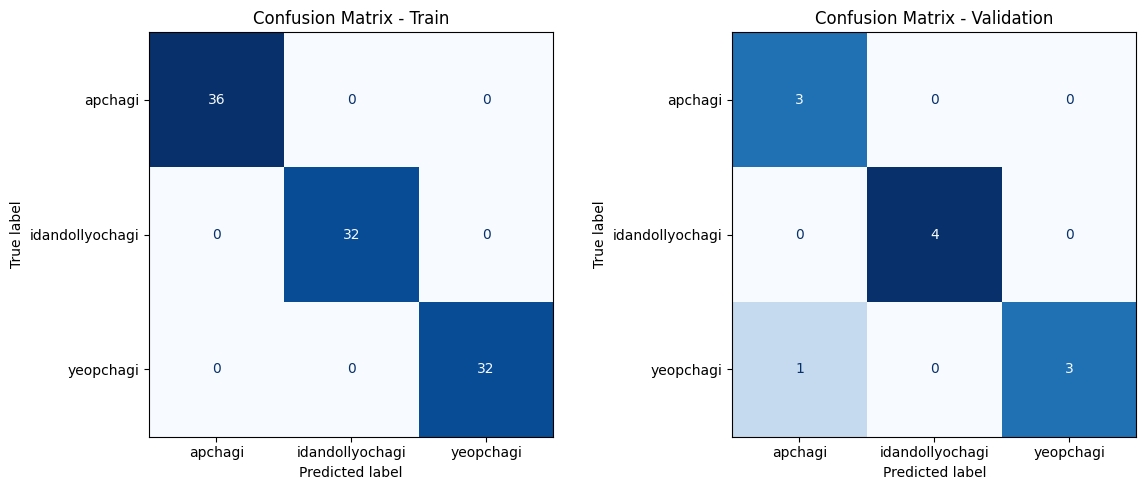

In [ ]:
print("\n" + "="*80)
print("Hasil Visualisasi")
print("="*80)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history_01.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_01.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history_01.history['loss'], label='Train Loss')
axes[1].plot(history_01.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


class_names = list(Label_map.keys())

def to_label(y):
    return np.argmax(y, axis=1) if len(y.shape) > 1 else y

# train
y_train_true = to_label(y_train_aug)
y_train_prob = model_01.predict(X_train_norm, verbose=0)
y_train_pred = np.argmax(y_train_prob, axis=1)

cm_train = confusion_matrix(y_train_true, y_train_pred)

# validation
y_val_true = to_label(y_val)
y_val_prob = model_01.predict(X_val_norm, verbose=0)
y_val_pred = np.argmax(y_val_prob, axis=1)

cm_val = confusion_matrix(y_val_true, y_val_pred)

# plot cm
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_title('Confusion Matrix - Train')

disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)
disp_val.plot(ax=axes[1], cmap='Blues', values_format='d', colorbar=False)
axes[1].set_title('Confusion Matrix - Validation')

plt.tight_layout()
plt.show()


In [ ]:
print("\n" + "="*80)
print("EVALUATING MODEL")
print("="*80)

# Evaluasi pada data testing
test_loss, test_acc = model_01.evaluate(X_test_norm, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Prediksi di test set
y_pred_prob = model_01.predict(X_test_norm)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=list(Label_map.keys())))

# Confusion matrix
cm_1 = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm_1)


EVALUATING MODEL

Test Loss: 0.2112
Test Accuracy: 91.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

CLASSIFICATION REPORT
                 precision    recall  f1-score   support

        apchagi       0.80      1.00      0.89         4
idandollyochagi       1.00      1.00      1.00         4
      yeopchagi       1.00      0.75      0.86         4

       accuracy                           0.92        12
      macro avg       0.93      0.92      0.92        12
   weighted avg       0.93      0.92      0.92        12


Confusion Matrix:
[[4 0 0]
 [0 4 0]
 [1 0 3]]


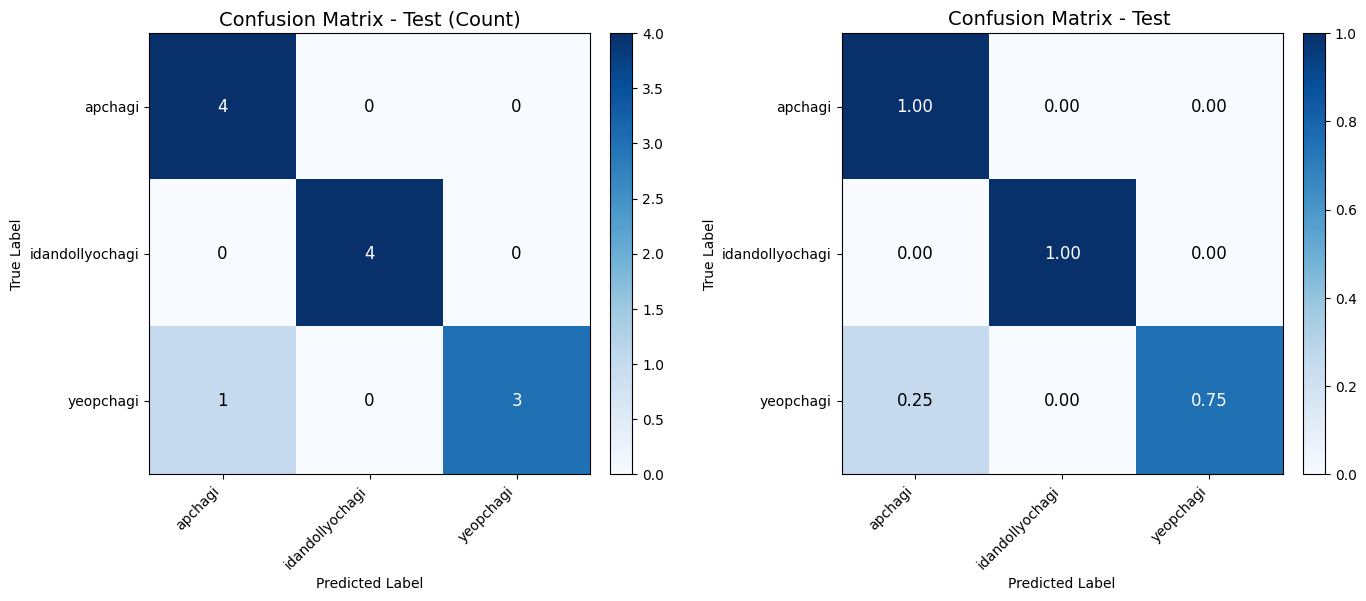

In [ ]:
from tensorflow.keras.models import load_model
MODEL_SAVE_PATH_B = '/content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_2LAYER.h5'

model2 = load_model(MODEL_SAVE_PATH_B)

class_names = list(Label_map.keys())

def to_label(y):
    return np.argmax(y, axis=1) if len(y.shape) > 1 else y

# prediksi data test
y_test_true = to_label(y_test)
y_test_prob = model2.predict(X_test_norm, verbose=0)
y_test_pred = np.argmax(y_test_prob, axis=1)

# confusion amtrix
cm_count = confusion_matrix(y_test_true, y_test_pred)                    # integer counts
cm_norm  = confusion_matrix(y_test_true, y_test_pred, normalize='true')  # 0-1

# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: count
ax = axes[0]
im1 = ax.imshow(cm_count, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Confusion Matrix - Test (Count)', fontsize=14)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

thresh = cm_count.max() / 2.0
for i in range(cm_count.shape[0]):
    for j in range(cm_count.shape[1]):
        ax.text(j, i, f'{cm_count[i, j]:d}',
                ha="center", va="center",
                color="white" if cm_count[i, j] > thresh else "black",
                fontsize=12)

fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

# Right: Scale
ax = axes[1]
im2 = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
ax.set_title('Confusion Matrix - Test ', fontsize=14)

ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f'{cm_norm[i, j]:.2f}',
                ha="center", va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black",
                fontsize=12)

fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


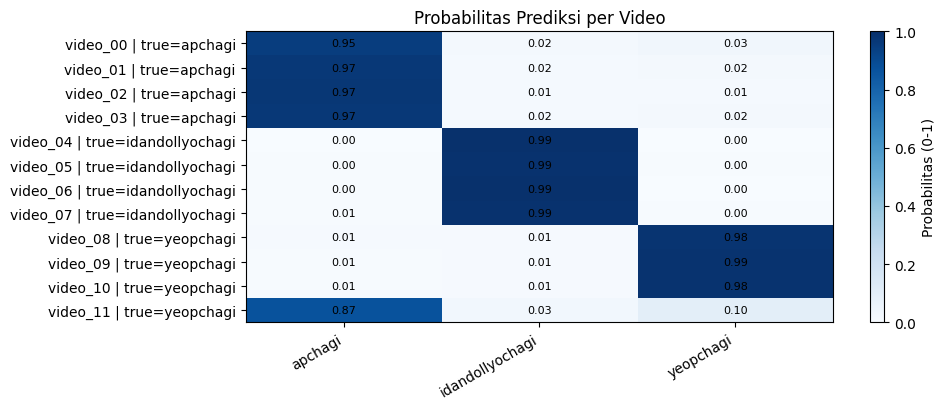

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class_names = ['apchagi','idandollyochagi','yeopchagi']

# y_test bisa one-hot atau label integer
y_true = np.argmax(y_test, axis=1) if getattr(y_test, "ndim", 1) > 1 else y_test

# probabilitas prediksi per video
probs = model_01.predict(X_test_norm, verbose=0)  # (N,3)

# label video (default: video_00, video_01, ...)
video_ids = [f'video_{i:02d}' for i in range(len(y_true))]

# urutkan berdasarkan kelas true supaya rapi
order = np.argsort(y_true)
probs_ord = probs[order]
y_true_ord = y_true[order]
video_ids_ord = [video_ids[i] for i in order]

# y-axis: video_00 | true=...
y_labels = [f'{vid} | true={class_names[t]}' for vid, t in zip(video_ids_ord, y_true_ord)]

plt.figure(figsize=(10, max(4, 0.35 * len(y_labels))))
im = plt.imshow(probs_ord, aspect='auto', vmin=0, vmax=1, cmap='Blues')
plt.colorbar(im, label='Probabilitas (0-1)')

plt.xticks(range(len(class_names)), class_names, rotation=30, ha='right')
plt.yticks(range(len(y_labels)), y_labels)
plt.title('Probabilitas Prediksi per Video')

# angka di setiap sel
for i in range(probs_ord.shape[0]):
    for j in range(probs_ord.shape[1]):
        plt.text(j, i, f'{probs_ord[i, j]:.2f}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()


### MODEL CNN + 1 LSTM

In [ ]:
def build_model_1LSTM32(sequence_len, num_features, num_classes):
    """
    Model CNN-LSTM 1 LAYER:
    - Conv1D + MaxPooling untuk ekstrak pola spasial
    - 1 LSTM untuk pola temporal
    """
    inputs = Input(shape=(sequence_len, num_features), name='input')

    # 1) Masking: abaikan padding (nilai 0)
    x = Masking(mask_value=0., name='masking')(inputs)

    # 2) Conv1D block
    x = Conv1D(64, kernel_size=5, activation='relu',
               padding='same', name='conv1d_1')(x)
    x = BatchNormalization(name='bn_1')(x)
    x = MaxPooling1D(pool_size=2, name='pool_1')(x)
    x = Dropout(0.2, name='dropout_1')(x)

    # 3) LSTM
    x = LSTM(32, return_sequences=False, name='lstm_1')(x)
    x = Dropout(0.2, name='dropout_2')(x)

    # 4) Dense + Dropout
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_3')(x)

    # 5) Output softmax
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs, name='Taekwondo_Classifier_1LSTM32')
    return model

print("Model architecture function (1LSTM32) defined.")

print("\n" + "="*80)
print("Building Model (1LSTM32)")
print("="*80)

tf.random.set_seed(42)
np.random.seed(42)

model_2 = build_model_1LSTM32(
    sequence_len=Sequence_Len,
    num_features=Num_Features,
    num_classes=Num_Classes
)

model_2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()


Model architecture function (1LSTM32) defined.

Building Model (1LSTM32)


Model: "Taekwondo_Classifier_1LSTM32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 30, 139)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 30, 139)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 64)         │        44,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling1D)           │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,523 (232.51 KB)

 Trainable params: 59,395 (232.01 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
print("\n" + "="*80)
print("Training Model (1LSTM32)")
print("="*80)

MODEL_SAVE_PATH_1LSTM32 = '/content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_1LAYER.h5'
os.makedirs(os.path.dirname(MODEL_SAVE_PATH_1LSTM32), exist_ok=True)

callbacks_1lstm32 = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-4,
        verbose=1
    ),
    ModelCheckpoint(
        MODEL_SAVE_PATH_1LSTM32,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


history_2 = model_2.fit(
    X_train_norm, y_train_aug,
    validation_data=(X_val_norm, y_val),
    epochs=50,
    batch_size=8,
    callbacks=callbacks_1lstm32,
    shuffle=True
)



Training Model (1LSTM32)
Epoch 1/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3533 - loss: 1.1358
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_1LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.3414 - loss: 1.1374 - val_accuracy: 0.0000e+00 - val_loss: 1.1644 - learning_rate: 1.0000e-04
Epoch 2/50
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3177 - loss: 1.1103
Epoch 2: val_accuracy improved from 0.00000 to 0.09091, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_1LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3263 - loss: 1.1028 - val_accuracy: 0.0909 - val_loss: 1.1345 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4494 - loss: 1.0223
Epoch 3: val_accuracy did not improve from 0.09091
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4558 - loss: 1.0200 - val_accuracy: 0.0909 - val_loss: 1.1053 - learning_rate: 1.0000e-04
Epoch 4/50
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5406 - loss: 0.9784
Epoch 4: val_accuracy improved from 0.09091 to 0.27273, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_1LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5537 - loss: 0.9723 - val_accuracy: 0.2727 - val_loss: 1.0833 - learning_rate: 1.0000e-04
Epoch 5/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5924 - loss: 0.9488
Epoch 5: val_accuracy did not improve from 0.27273
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6007 - loss: 0.9425 - val_accuracy: 0.2727 - val_loss: 1.0646 - learning_rate: 1.0000e-04
Epoch 6/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6019 - loss: 0.9433
Epoch 6: val_accuracy improved from 0.27273 to 0.36364, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_1LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6160 - loss: 0.9335 - val_accuracy: 0.3636 - val_loss: 1.0455 - learning_rate: 1.0000e-04
Epoch 7/50
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6434 - loss: 0.8617
Epoch 7: val_accuracy improved from 0.36364 to 0.54545, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_1LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6655 - loss: 0.8525 - val_accuracy: 0.5455 - val_loss: 1.0183 - learning_rate: 1.0000e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6997 - loss: 0.8205
Epoch 8: val_accuracy did not improve from 0.54545
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7047 - loss: 0.8168 - val_accuracy: 0.5455 - val_loss: 0.9904 - learning_rate: 1.0000e-04
Epoch 9/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6854 - loss: 0.8190
Epoch 9: val_accuracy did not improve from 0.54545
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7004 - loss: 0.8103 - val_accuracy: 0.5455 - val_loss: 0.9612 - learning_rate: 1.0000e-04
Epoch 10/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7589 - loss: 0.7522
Epoch 10: val_accuracy did not improve from 0.54545
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7690 - loss: 0.7454 - val_accuracy: 0.5455 - val_loss: 0.9290 - learning_rate: 1.0000e-04
Epoch 11/50
12

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8788 - loss: 0.6034 - val_accuracy: 0.6364 - val_loss: 0.8299 - learning_rate: 1.0000e-04
Epoch 16/50
 9/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8439 - loss: 0.6112
Epoch 16: val_accuracy improved from 0.63636 to 0.72727, saving model to /content/drive/MyDrive/taekwondo_pose/MODEL_CNNLSTM_1LAYER.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8665 - loss: 0.5798 - val_accuracy: 0.7273 - val_loss: 0.8194 - learning_rate: 1.0000e-04
Epoch 17/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8667 - loss: 0.5379
Epoch 17: val_accuracy did not improve from 0.72727
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8743 - loss: 0.5283 - val_accuracy: 0.7273 - val_loss: 0.8166 - learning_rate: 1.0000e-04
Epoch 18/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9300 - loss: 0.4972
Epoch 18: val_accuracy did not improve from 0.72727
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9357 - loss: 0.4888 - val_accuracy: 0.7273 - val_loss: 0.8026 - learning_rate: 1.0000e-04
Epoch 19/50
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8812 - loss: 0.5095
Epoch 19: val_accuracy did not improve from 0.72727
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8936 - loss: 0.4929 - val_accuracy: 0.7273 - val_loss: 0.7821 - learning_rate: 1.0000e-04
Epoch 20/5

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0834 - val_accuracy: 0.8182 - val_loss: 0.6829 - learning_rate: 1.0000e-04
Epoch 49/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0745
Epoch 49: val_accuracy did not improve from 0.81818
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0728 - val_accuracy: 0.7273 - val_loss: 0.6999 - learning_rate: 1.0000e-04
Epoch 50/50
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0832
Epoch 50: val_accuracy did not improve from 0.81818
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 1.0000 - loss: 0.0816 - val_accuracy: 0.7273 - val_loss: 0.7249 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 38.


### PERFORMA MODEL


Hasil Visualisasi


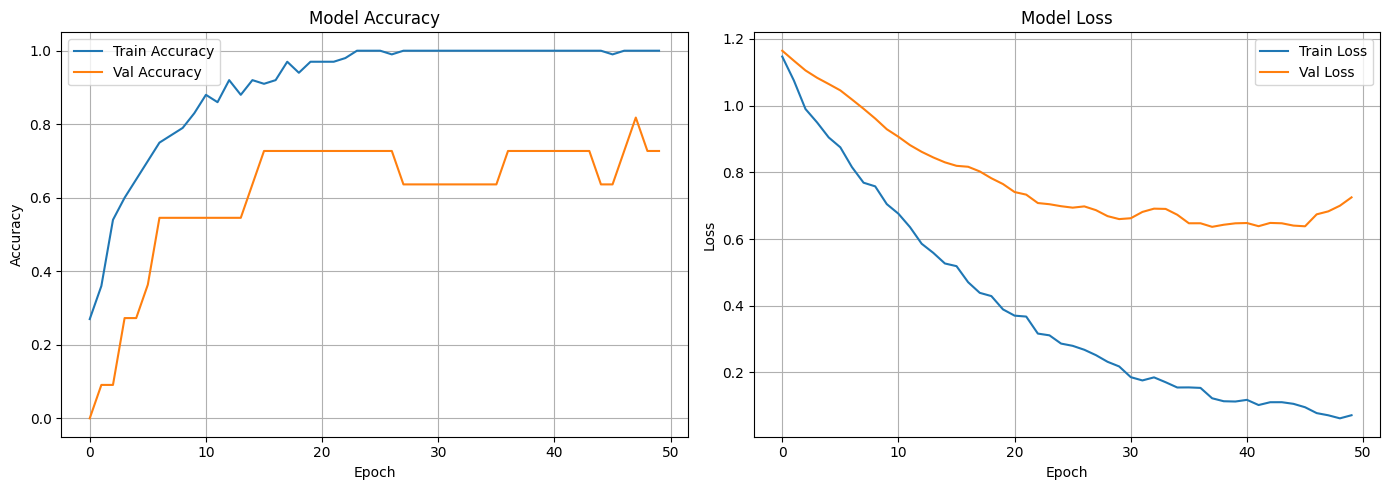

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


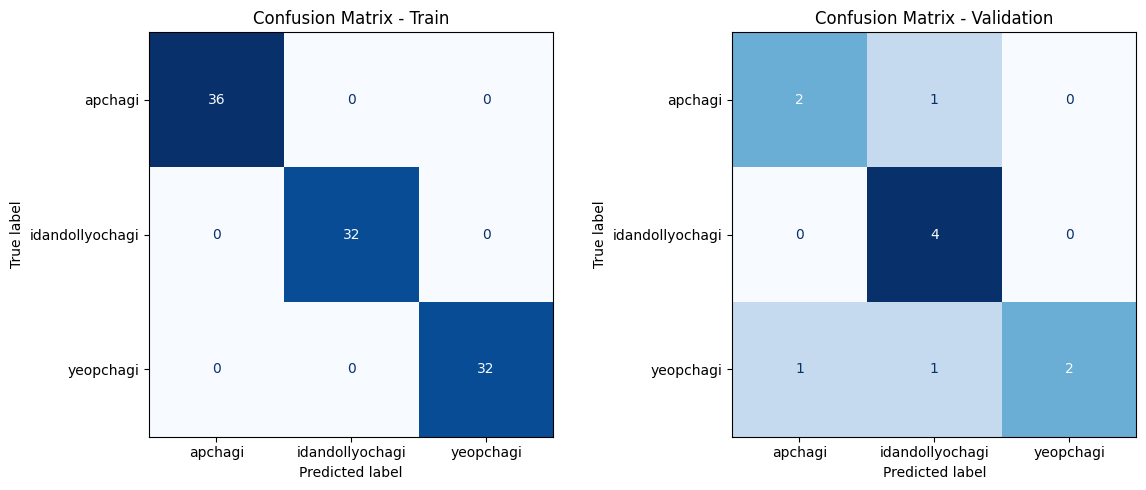

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n" + "="*80)
print("Hasil Visualisasi")
print("="*80)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history_2.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_2.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history_2.history['loss'], label='Train Loss')
axes[1].plot(history_2.history['val_loss'], label='Val Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Plot confusion matrix
class_names = ['apchagi', 'idandollyochagi', 'yeopchagi']

def to_label(y):
    return np.argmax(y, axis=1) if len(y.shape) > 1 else y

# train
y_train_true = to_label(y_train_aug)
y_train_prob = model_2.predict(X_train_norm, verbose=0)
y_train_pred = np.argmax(y_train_prob, axis=1)

cm_train = confusion_matrix(y_train_true, y_train_pred)

# validation
y_val_true = to_label(y_val)
y_val_prob = model_2.predict(X_val_norm, verbose=0)
y_val_pred = np.argmax(y_val_prob, axis=1)

cm_val = confusion_matrix(y_val_true, y_val_pred)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
axes[0].set_title('Confusion Matrix - Train')

disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=class_names)
disp_val.plot(ax=axes[1], cmap='Blues', values_format='d', colorbar=False)
axes[1].set_title('Confusion Matrix - Validation')

plt.tight_layout()
plt.show()


### EVALUASI MODEL

In [ ]:
print("\n" + "="*80)
print("EVALUATING MODEL (1LSTM32)")
print("="*80)

test_loss_2, test_acc_2 = model_2.evaluate(X_test_norm, y_test, verbose=0)
print(f"\nTest Loss: {test_loss_2:.4f}")
print(f"Test Accuracy: {test_acc_2*100:.2f}%")

y_pred_prob_2 = model_2.predict(X_test_norm)
y_pred_2 = np.argmax(y_pred_prob_2, axis=1)
y_true_2 = np.argmax(y_test, axis=1)

print(classification_report(y_true_2, y_pred_2, target_names=list(Label_map.keys())))

cm_2 = confusion_matrix(y_true_2, y_pred_2)
print(cm_2)



EVALUATING MODEL (1LSTM32)

Test Loss: 0.4669
Test Accuracy: 83.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
                 precision    recall  f1-score   support

        apchagi       1.00      1.00      1.00         4
idandollyochagi       0.67      1.00      0.80         4
      yeopchagi       1.00      0.50      0.67         4

       accuracy                           0.83        12
      macro avg       0.89      0.83      0.82        12
   weighted avg       0.89      0.83      0.82        12

[[4 0 0]
 [0 4 0]
 [0 2 2]]


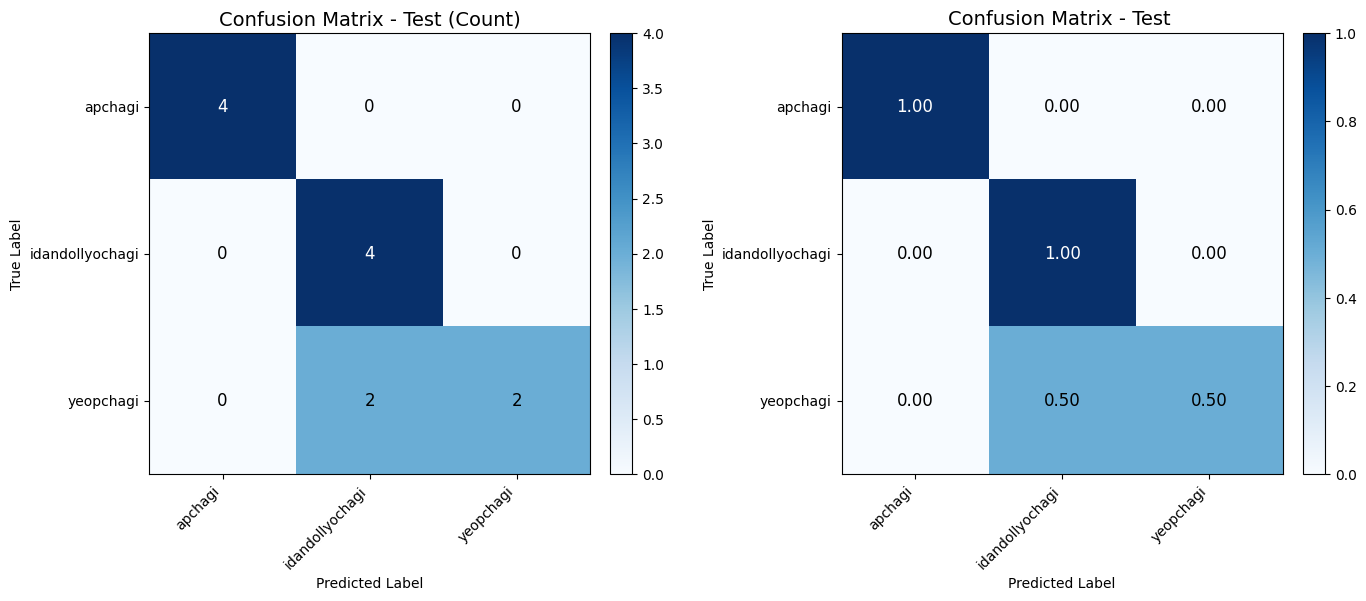

In [ ]:
class_names = list(Label_map.keys())

# prediksi data test
y_test_true = to_label(y_test)
y_test_prob = model_2.predict(X_test_norm, verbose=0)
y_test_pred = np.argmax(y_test_prob, axis=1)

# confusion amtrix
cm_count = confusion_matrix(y_test_true, y_test_pred)                    # integer counts
cm_norm  = confusion_matrix(y_test_true, y_test_pred, normalize='true')  # 0-1

# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: count
ax = axes[0]
im1 = ax.imshow(cm_count, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Confusion Matrix - Test (Count)', fontsize=14)

tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

thresh = cm_count.max() / 2.0
for i in range(cm_count.shape[0]):
    for j in range(cm_count.shape[1]):
        ax.text(j, i, f'{cm_count[i, j]:d}',
                ha="center", va="center",
                color="white" if cm_count[i, j] > thresh else "black",
                fontsize=12)

fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

# Right: Scale
ax = axes[1]
im2 = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
ax.set_title('Confusion Matrix - Test ', fontsize=14)

ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f'{cm_norm[i, j]:.2f}',
                ha="center", va="center",
                color="white" if cm_norm[i, j] > 0.5 else "black",
                fontsize=12)

fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


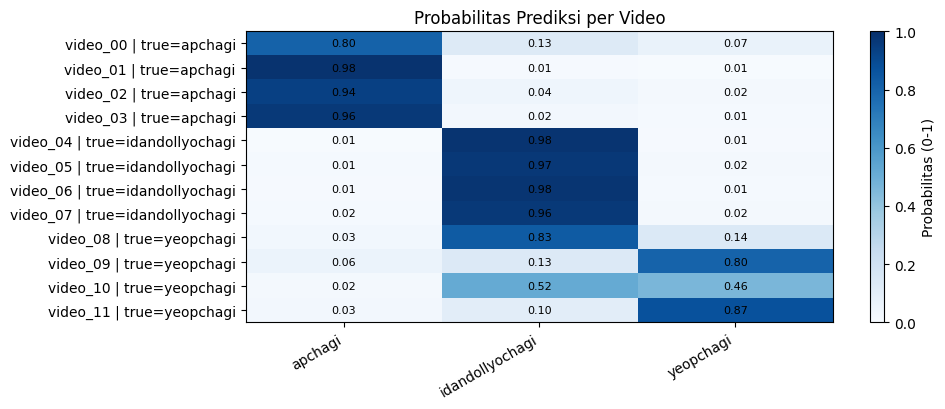

In [ ]:
class_names = list(Label_map.keys())

y_true = np.argmax(y_test, axis=1) if getattr(y_test, "ndim", 1) > 1 else y_test

# probabilitas prediksi per video
probs = model_2.predict(X_test_norm, verbose=0)  # (N,3)

# label video (default: video_00, video_01, ...)
video_ids = [f'video_{i:02d}' for i in range(len(y_true))]

order = np.argsort(y_true)
probs_ord = probs[order]
y_true_ord = y_true[order]
video_ids_ord = [video_ids[i] for i in order]

# y-axis
y_labels = [f'{vid} | true={class_names[t]}' for vid, t in zip(video_ids_ord, y_true_ord)]

plt.figure(figsize=(10, max(4, 0.35 * len(y_labels))))
im = plt.imshow(probs_ord, aspect='auto', vmin=0, vmax=1, cmap='Blues')
plt.colorbar(im, label='Probabilitas (0-1)')

plt.xticks(range(len(class_names)), class_names, rotation=30, ha='right')
plt.yticks(range(len(y_labels)), y_labels)
plt.title('Probabilitas Prediksi per Video')

for i in range(probs_ord.shape[0]):
    for j in range(probs_ord.shape[1]):
        plt.text(j, i, f'{probs_ord[i, j]:.2f}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()
